# Ingeniería de Características: Creación de Nuevas Variables (Core)
**Descripción:**

En esta actividad, trabajarás con el dataset «Titanic – Machine Learning from Disaster» disponible en Kaggle para realizar ingeniería de características. El objetivo es crear nuevas variables a partir de las existentes y evaluar cómo estas nuevas características pueden mejorar la capacidad predictiva de un modelo de machine learning.

Enlace al dataset: https://www.kaggle.com/c/titanic

**Objetivo:**

El objetivo principal es desarrollar habilidades en la creación de nuevas variables que capturen información útil no presente en las variables originales. Estas nuevas características serán utilizadas para mejorar el rendimiento de un modelo de clasificación que prediga la supervivencia de los pasajeros del Titanic.


**Instrucciones:**

1. Carga de datos:
- Descarga y carga el dataset «Titanic» desde Kaggle. Realiza una exploración inicial de las variables disponibles, que incluyen información sobre la edad, el género, la clase del pasajero, entre otros.
- Examina cuántos valores faltan en las variables importantes como la edad y el precio del boleto.

In [1]:
# Agregar la carpeta 'src' al sys.path
import sys
import os

# Buscar 'src' automáticamente sin depender del nombre del proyecto
current_dir = os.getcwd()  # Directorio actual
while not os.path.exists(os.path.join(current_dir, "src")):
    current_dir = os.path.dirname(current_dir)  # Subir un nivel
    if current_dir == "/":  # Evitar bucles infinitos
        raise FileNotFoundError("No se encontró la carpeta 'src'. Verifica la estructura.")

src_path = os.path.join(current_dir, "src")
if src_path not in sys.path:
    sys.path.append(src_path)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_curve,auc, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.datasets import load_digits
from sklearn.datasets import load_iris

from utils import cargar_datos_pd
from utils import dimensiones
from utils import ver_resumen_nulos
from utils import identificar_atipicos_IQR
from utils import ver_diccionario
from utils import imprimir_bigotes
from utils import plot_varianza
from utils import filtrar_columnas
from utils import desc
from utils import imprimir_bigotes_por_grupo
from utils import generar_diccionario
from utils import obtener_filas_no_numericas

# 1. Carga de datos

In [2]:
diccionario = '../../data/titanic_diccionario.csv'
ruta_archivo='../../data/titanic_train.csv'

df = cargar_datos_pd(ruta_archivo,sep=',', header=0)
df_bkp = df.copy()

Dataset cargado con éxito.


In [3]:
ver_resumen_nulos(df)

,datos sin NAs en q,Na en q,Na en %
Cabin,204,687,77.10
Age,714,177,19.87
Embarked,889,2,0.22
PassengerId,891,0,0.00
Name,891,0,0.00
Pclass,891,0,0.00
Survived,891,0,0.00
Sex,891,0,0.00
Parch,891,0,0.00
SibSp,891,0,0.00


In [4]:
# NO Voy a Eliminar la columna Cabin number, pues la vamos a usar para crear una nueva variable
#df = df.drop('Cabin', axis=1)

In [5]:
df['Age'].describe().T

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: Age, dtype: float64

In [6]:
desc(df,['Age'])

,count,mean,std,min,25%,50%,75%,max,%std/mean
Age,714.0,29.699118,14.526497,0.42,20.125,28.0,38.0,80.0,48.91


In [7]:
# Aplicamos la mediana a la columna Age
df['Age'] = df['Age'].fillna(df['Age'].median())

In [8]:
# Columna Embarked
df['Embarked'].value_counts()

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

In [9]:
df['Embarked'].describe().T

count     889
unique      3
top         S
freq      644
Name: Embarked, dtype: object

In [10]:
# Aplicamos la mediana a la columna Embarked
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [12]:
df['Cabin'].value_counts().T

Cabin
G6             4
C23 C25 C27    4
B96 B98        4
F2             3
D              3
              ..
E17            1
A24            1
C50            1
B42            1
C148           1
Name: count, Length: 147, dtype: int64

Al revisar Ticket vemos que tiene cierto dato que puede relacionarse con Cabina.

Vamos a crear una columna Ticket_Cabina y Ticket_Numero donde vamos a serpar la primera parte del Ticket como dato de cabina y la segunda como numero.

Luego vamos a convertir a numero Ticket_Numero

Pero antes vamos a revisar los patrones que existen en Ticket.

In [13]:
# Crear una expresión regular para identificar patrones
import re

# Función para extraer el patrón de un valor
def extraer_patron(ticket):
    # Divide por espacios y reemplaza números con un marcador genérico
    return re.sub(r'\d+', '<NUM>', ticket)
# Creamo una copia
df_aux = df.copy()
# Crear una nueva columna con los patrones extraídos
df_aux['Patron'] = df['Ticket'].apply(extraer_patron)

# Obtener solo el primer caso de cada patrón único
patrones_unicos = df_aux.drop_duplicates(subset=['Patron'])

# Mostrar los patrones únicos y el primer caso asociado
print(patrones_unicos[['Ticket', 'Patron']])


                 Ticket               Patron
0             A/5 21171        A/<NUM> <NUM>
1              PC 17599             PC <NUM>
2      STON/O2. 3101282   STON/O<NUM>. <NUM>
3                113803                <NUM>
10              PP 9549             PP <NUM>
12            A/5. 2151       A/<NUM>. <NUM>
33           C.A. 24579           C.A. <NUM>
37           A./5. 2152      A./<NUM>. <NUM>
43        SC/Paris 2123       SC/Paris <NUM>
45      S.C./A.4. 23567  S.C./A.<NUM>. <NUM>
59              CA 2144             CA <NUM>
67            S.P. 3464           S.P. <NUM>
72         S.O.C. 14879         S.O.C. <NUM>
84           SO/C 14885           SO/C <NUM>
86           W./C. 6608          W./C. <NUM>
87      SOTON/OQ 392086       SOTON/OQ <NUM>
92          W.E.P. 5734         W.E.P. <NUM>
115   STON/O 2. 3101294  STON/O <NUM>. <NUM>
121           A4. 54510        A<NUM>. <NUM>
127             C 17369              C <NUM>
131  SOTON/O.Q. 3101307     SOTON/O.Q. <NUM>
135       

In [14]:
import numpy as np
import re

# Función para extraer el último número del ticket
def extraer_ultimo_num(ticket):
    # Buscar todas las secuencias de dígitos en el ticket
    matches = re.findall(r'\d+', ticket)
    # Si encuentra números, retorna el último; si no, retorna np.nan
    return matches[-1] if matches else np.nan

# Aplicar la función a la columna 'Ticket'
df['Ticket_Numero'] = df['Ticket'].apply(extraer_ultimo_num)

# Mostrar los resultados
print(df[['Ticket', 'Ticket_Numero']].head())



             Ticket Ticket_Numero
0         A/5 21171         21171
1          PC 17599         17599
2  STON/O2. 3101282       3101282
3            113803        113803
4            373450        373450


In [15]:
df[df['Ticket_Numero'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_Numero
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,NaN
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,NaN
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,NaN
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,NaN


In [16]:
#Vamos a crear el tipo de Ticket que es Normal para los numericos y LINE para los Linea
# Asignamos 'LINE' si es nulo, 'Normal' si es numérico, y 'LINE' si no lo es
df['Tipo_Ticket'] = np.where(pd.isna(df['Ticket_Numero']), 'LINE', 
                             np.where(df['Ticket_Numero'].str.isnumeric(), 'Normal', 'LINE'))


In [17]:
df['Tipo_Ticket'].value_counts()

Tipo_Ticket
Normal    887
LINE        4
Name: count, dtype: int64

In [18]:
df[df['Ticket_Numero'].isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_Numero,Tipo_Ticket
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,NaN,LINE
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,NaN,LINE
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,NaN,LINE
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,NaN,LINE


In [19]:
df[df['Tipo_Ticket']=='LINE']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_Numero,Tipo_Ticket
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,NaN,S,NaN,LINE
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,NaN,S,NaN,LINE
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,NaN,S,NaN,LINE
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,NaN,S,NaN,LINE


In [20]:
import re
import numpy as np

# Función para extraer el ticket sin la última parte numérica
def extraer_sin_ultimo_num(ticket):
    # Buscar todas las secuencias de dígitos en el ticket
    matches = re.findall(r'\d+', ticket)
    # Si encuentra números, elimina la última parte numérica y retorna el resto; si no, retorna el ticket completo
    if matches:
        # Elimina el último número de la lista de matches
        ticket_sin_ultimo_num = re.sub(r'\d+$', '', ticket)
        return ticket_sin_ultimo_num
    return ticket  # Si no hay números, retorna el ticket tal cual


In [21]:
# Aplicar la función a la columna 'Ticket' para extraer la parte sin el último número
df['Ticket_Cabina'] = df['Ticket'].apply(extraer_sin_ultimo_num)

# Mostrar los resultados
df[['Pclass','Cabin','Ticket', 'Ticket_Cabina']].head()


,Pclass,Cabin,Ticket,Ticket_Cabina
0,3,NaN,A/5 21171,A/5
1,1,C85,PC 17599,PC
2,3,NaN,STON/O2. 3101282,STON/O2.
3,1,C123,113803,
4,3,NaN,373450,


Depurar las siglas de las empresas que vendieron los tickets.

In [22]:
# Limpiar y normalizar las siglas
df['Ticket_Cabina'] = df['Ticket_Cabina'].str.strip()

In [23]:
df['Ticket_Cabina'].value_counts()

Ticket_Cabina
               661
PC              60
C.A.            27
STON/O 2.       12
A/5             10
W./C.            9
CA.              8
SOTON/O.Q.       8
SOTON/OQ         7
A/5.             7
CA               6
STON/O2.         6
F.C.C.           5
SC/PARIS         5
S.O.C.           5
C                5
LINE             4
SC/Paris         4
PP               3
A/4              3
A/4.             3
S.O./P.P.        3
S.C./PARIS       2
A./5.            2
WE/P             2
SC/AH            2
P/PP             2
A.5.             2
SOTON/O2         2
S.P.             1
S.C./A.4.        1
Fa               1
A4.              1
SO/C             1
S.O.P.           1
W.E.P.           1
SW/PP            1
SC/AH Basle      1
A/S              1
SC               1
SCO/W            1
W/C              1
S.W./PP          1
F.C.             1
C.A./SOTON       1
Name: count, dtype: int64

Paso 1: Identificar y depurar las siglas

Unificar Siglas

In [24]:
# Mapa para reducir las siglas
mapa_reduccion_siglas = {
    # White Star Line
    "A/5.": "A/5",
    "A./5.": "A/5",
    "A4.": "A/5",
    "A/4.": "A/5",
    "A/4": "A/5",
    "W./C.": "A/5",
    "W/C": "A/5",
    
    # Peninsular & Oriental Steam Navigation
    "PC": "PC",
    
    # Standard Oil Company
    "S.O.C.": "S.O.C.",
    "SO/C": "S.O.C.",
    
    # Southampton Office (SOC)
    "SOTON/O2": "SOTON/OQ",
    "SOTON/O.Q.": "SOTON/OQ",
    "SOTON/OQ": "SOTON/OQ",
    
    # Cunard Line
    "CA": "C.A.",
    "CA.": "C.A.",
    "C.A./SOTON": "C.A.",
    
    # Compagnie Générale Transatlantique
    "SC/PARIS": "SC/PARIS",
    "SC/Paris": "SC/PARIS",
    "S.C./PARIS": "SC/PARIS",
    
    # Line
    "LINE": "LINE",
    
    # Federal Commerce Commission
    "F.C.": "F.C.C.",
    "F.C.C.": "F.C.C.",
    
    # Otros grupos
    "STON/O 2.": "STON/O2",
    "STON/O2.": "STON/O2",
    "PP": "PP",
    "P/PP": "PP",
    "S.W./PP": "PP",
    "SW/PP": "PP",
    "SCO/W": "SCO/W",
}

# Función para reducir las siglas
def reducir_sigla(sigla):
    return mapa_reduccion_siglas.get(sigla.strip(), sigla.strip())

# Aplicar la función al DataFrame
df['Ticket_Sigla_Reducida'] = df['Ticket_Cabina'].apply(reducir_sigla)

# Verificar el resultado
df[['Ticket_Cabina', 'Ticket_Sigla_Reducida']].drop_duplicates()


,Ticket_Cabina,Ticket_Sigla_Reducida
0,A/5,A/5
1,PC,PC
2,STON/O2.,STON/O2
3,,
10,PP,PP
12,A/5.,A/5
33,C.A.,C.A.
37,A./5.,A/5
43,SC/Paris,SC/PARIS
45,S.C./A.4.,S.C./A.4.


In [25]:
# Mapeo actualizado de siglas únicas a nombres de compañías
mapeo_sigla_empresa = {
    "A/5": "White Star Line",
    "PC": "Peninsular & Oriental Steam Navigation Company (P&O)",
    "S.O.C.": "Standard Oil Company",
    "SOTON/OQ": "Southampton Office (SOC)",
    "C.A.": "Cunard Line",
    "SC/PARIS": "Compagnie Générale Transatlantique",
    "LINE": "Line (pasajeros sin cabina asignada)",
    "F.C.C.": "Federal Commerce Commission",
    "STON/O2": "Stone Oil Company",
    "PP": "Pacific & Panama Steamship Company",
    "SCO/W": "Scottish Wholesale Society",
}


In [26]:
# Función para obtener el nombre de la empresa a partir de la sigla reducida
def obtener_nombre_empresa(sigla):
    return mapeo_sigla_empresa.get(sigla, "Empresa no identificada")

# Aplicar la función al DataFrame
df['Nombre_Empresa'] = df['Ticket_Sigla_Reducida'].apply(obtener_nombre_empresa)

# Verificar el resultado
df[['Ticket_Sigla_Reducida', 'Nombre_Empresa']].drop_duplicates()


,Ticket_Sigla_Reducida,Nombre_Empresa
0,A/5,White Star Line
1,PC,Peninsular & Oriental Steam Navigation Company...
2,STON/O2,Stone Oil Company
3,,Empresa no identificada
10,PP,Pacific & Panama Steamship Company
33,C.A.,Cunard Line
43,SC/PARIS,Compagnie Générale Transatlantique
45,S.C./A.4.,Empresa no identificada
67,S.P.,Empresa no identificada
72,S.O.C.,Standard Oil Company


In [27]:
df['Nombre_Empresa'].value_counts()

Nombre_Empresa
Empresa no identificada                                 683
Peninsular & Oriental Steam Navigation Company (P&O)     60
Cunard Line                                              42
White Star Line                                          36
Stone Oil Company                                        18
Southampton Office (SOC)                                 17
Compagnie Générale Transatlantique                       11
Pacific & Panama Steamship Company                        7
Standard Oil Company                                      6
Federal Commerce Commission                               6
Line (pasajeros sin cabina asignada)                      4
Scottish Wholesale Society                                1
Name: count, dtype: int64

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   PassengerId            891 non-null    int64  
 1   Survived               891 non-null    int64  
 2   Pclass                 891 non-null    int64  
 3   Name                   891 non-null    object 
 4   Sex                    891 non-null    object 
 5   Age                    891 non-null    float64
 6   SibSp                  891 non-null    int64  
 7   Parch                  891 non-null    int64  
 8   Ticket                 891 non-null    object 
 9   Fare                   891 non-null    float64
 10  Cabin                  204 non-null    object 
 11  Embarked               891 non-null    object 
 12  Ticket_Numero          887 non-null    object 
 13  Tipo_Ticket            891 non-null    object 
 14  Ticket_Cabina          891 non-null    object 
 15  Ticket

In [29]:
# Asignamos cero a los nulos en Ticket_Numero
df['Ticket_Numero']= df['Ticket_Numero'].fillna(0)

In [30]:
# Ahora Asignar Ticket con el Ticket_Numero
df['Ticket'] = df['Ticket_Numero'].astype(str)

In [31]:
# Renombramo Ticket_Sigla_Reducida a Sigla_Empresa
df.rename(columns={'Ticket_Sigla_Reducida': 'Sigla_Empresa'}, inplace=True)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             891 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           204 non-null    object 
 11  Embarked        891 non-null    object 
 12  Ticket_Numero   891 non-null    object 
 13  Tipo_Ticket     891 non-null    object 
 14  Ticket_Cabina   891 non-null    object 
 15  Sigla_Empresa   891 non-null    object 
 16  Nombre_Empresa  891 non-null    object 
dtypes: float64(2), int64(5), object(10)

In [33]:
df.head().T

,0,1,2,3,4
PassengerId,1,2,3,4,5
Survived,0,1,1,1,0
Pclass,3,1,3,1,3
Name,"Braund, Mr. Owen Harris","Cumings, Mrs. John Bradley (Florence Briggs Th...","Heikkinen, Miss. Laina","Futrelle, Mrs. Jacques Heath (Lily May Peel)","Allen, Mr. William Henry"
Sex,male,female,female,female,male
Age,22.0,38.0,26.0,35.0,35.0
SibSp,1,1,0,1,0
Parch,0,0,0,0,0
Ticket,21171,17599,3101282,113803,373450
Fare,7.25,71.2833,7.925,53.1,8.05


In [34]:
# Eliminar las columnas Ticket_Numero,Tipo_Ticket y Ticket_Cabina
df.drop(columns=['Ticket_Numero', 'Tipo_Ticket', 'Ticket_Cabina'], inplace=True)

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PassengerId     891 non-null    int64  
 1   Survived        891 non-null    int64  
 2   Pclass          891 non-null    int64  
 3   Name            891 non-null    object 
 4   Sex             891 non-null    object 
 5   Age             891 non-null    float64
 6   SibSp           891 non-null    int64  
 7   Parch           891 non-null    int64  
 8   Ticket          891 non-null    object 
 9   Fare            891 non-null    float64
 10  Cabin           204 non-null    object 
 11  Embarked        891 non-null    object 
 12  Sigla_Empresa   891 non-null    object 
 13  Nombre_Empresa  891 non-null    object 
dtypes: float64(2), int64(5), object(7)
memory usage: 97.6+ KB


Paso 2: Crear una columna de siglas depuradas

No hay valores nulos

In [36]:
# Identificar duplicados
duplicados = df[df.duplicated(keep=False)]

# Mostrar los duplicados encontrados
if not duplicados.empty:
    print("Duplicados eliminados:")
    print(duplicados)
else:
    print("No se encontraron duplicados para eliminar.")

# Eliminar duplicados
df = df.drop_duplicates()

No se encontraron duplicados para eliminar.


Ticket es numerico pero está como object ... vamos a convertirlo a numero.
Pero creo que las familias tienen el mismo ticket.

In [37]:
# Detectar columnas con valores únicos ['Yes', 'No']
yes_no_columns = [col for col in df.columns if sorted(df[col].dropna().unique()) == ['No', 'Yes']]
print("Columnas con valores 'Yes' y 'No':", yes_no_columns)
# Aplicar el mapeo 'Yes' -> 1 y 'No' -> 0 a todas las columnas de una vez usando map y itertools
df[yes_no_columns] = pd.DataFrame(
    map(lambda col: df[col].map({'Yes': 1, 'No': 0}), yes_no_columns)
).T.set_axis(yes_no_columns, axis=1)

Columnas con valores 'Yes' y 'No': []


Diccionario de datos del df.

In [38]:
generar_diccionario(df)

data_dict = {
    'PassengerId': 'int64',
    'Survived': 'int64',
    'Pclass': 'int64',
    'Name': 'object',
    'Sex': 'object',
    'Age': 'float64',
    'SibSp': 'int64',
    'Parch': 'int64',
    'Ticket': 'object',
    'Fare': 'float64',
    'Cabin': 'object',
    'Embarked': 'object',
    'Sigla_Empresa': 'object',
    'Nombre_Empresa': 'object',
}


In [39]:
data_dict = {
    
    'PassengerId': 'int64',
    'Survived': 'int64',
    'Pclass': 'int64',
    'Name': 'string',
    'Sex': 'category',
    'Age': 'float64',
    'SibSp': 'int64',
    'Parch': 'int64',
    'Ticket': 'int64',
    'Fare': 'float64',
    'Cabin': 'string',
    'Embarked': 'category',
    'Sigla_Empresa': 'string',
    'Nombre_Empresa': 'string'
}

# Convertir tipos de datos según el diccionario
for column, dtype in data_dict.items():
    df[column] = df[column].astype(dtype, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    int64   
 3   Name            891 non-null    string  
 4   Sex             891 non-null    category
 5   Age             891 non-null    float64 
 6   SibSp           891 non-null    int64   
 7   Parch           891 non-null    int64   
 8   Ticket          891 non-null    int64   
 9   Fare            891 non-null    float64 
 10  Cabin           204 non-null    string  
 11  Embarked        891 non-null    category
 12  Sigla_Empresa   891 non-null    string  
 13  Nombre_Empresa  891 non-null    string  
dtypes: category(2), float64(2), int64(6), string(4)
memory usage: 85.7 KB


Ticket YA es completamente numerico.


In [40]:
# Ver cuantos tipos de valores tiene Cabin, inclyendo los nulos
df['Cabin'].value_counts(dropna=False)

Cabin
<NA>           687
G6               4
C23 C25 C27      4
B96 B98          4
F2               3
              ... 
E17              1
A24              1
C50              1
B42              1
C148             1
Name: count, Length: 148, dtype: Int64

In [41]:
# Asignar None a Cabin
df['Cabin'] = df['Cabin'].fillna('None')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     891 non-null    int64   
 1   Survived        891 non-null    int64   
 2   Pclass          891 non-null    int64   
 3   Name            891 non-null    string  
 4   Sex             891 non-null    category
 5   Age             891 non-null    float64 
 6   SibSp           891 non-null    int64   
 7   Parch           891 non-null    int64   
 8   Ticket          891 non-null    int64   
 9   Fare            891 non-null    float64 
 10  Cabin           891 non-null    string  
 11  Embarked        891 non-null    category
 12  Sigla_Empresa   891 non-null    string  
 13  Nombre_Empresa  891 non-null    string  
dtypes: category(2), float64(2), int64(6), string(4)
memory usage: 85.7 KB


### **Consistencia en valores categóricos**

Identifica y corrige cualquier inconsistencia en los valores categóricos (por ejemplo, ‘Junior’, ‘junior’, ‘JUNIOR’)

In [43]:
# Identificar columnas de tipo 'object', típicamente usadas para variables categóricas
categorical_columns = df.select_dtypes(include=['category','bool']).columns
# Crear un diccionario donde cada clave es el nombre de la columna y los valores son los valores únicos de esa columna
unique_values_dict = {col: df[col].unique() for col in categorical_columns}
# Convertir el diccionario en un DataFrame, rellenando con NaN cuando haya menos valores únicos
unique_values_df = pd.DataFrame.from_dict(unique_values_dict, orient='index').transpose()
# Mostrar el DataFrame resultante
unique_values_df.T

,0,1,2
Sex,male,female,None
Embarked,S,C,Q


In [44]:
#Hacemos una copia del df
df_sin_nuevas_caracteristicas = df.copy()

# 3. Creación de nuevas características:
- Tamaño de la familia: Combina las variables «SibSp» (número de hermanos/esposos) y «Parch» (número de padres/hijos) para crear una variable que represente el tamaño total de la familia del pasajero.

In [45]:
df['Tamaño_Familia'] = df['SibSp'] + df['Parch'] + 1


- Cabina desconocida: Crea una variable binaria que indique si la cabina de un pasajero es conocida o no, lo cual podría estar relacionado con la clase o la ubicación a bordo.

In [46]:
# Crear la nueva variable binaria 'Cabina_Desconocida' (1 si es desconocida, 0 si es conocida)
df['Cabina_Desconocida'] = df['Cabin'].apply(lambda x: 1 if pd.isnull(x) or x == 'None' else 0)

# Mostrar el resultado
print(df[['Cabin', 'Cabina_Desconocida']].head())



  Cabin  Cabina_Desconocida
0  None                   1
1   C85                   0
2  None                   1
3  C123                   0
4  None                   1


In [47]:
# Ver la descripcion de la variable Fare por Pclass, donde tamaño familia sea 1 
# Filtrar los registros donde Tamaño Familia = 1
df_familia_1 = df[df['Tamaño_Familia'] == 1]

# Obtener la descripción estadística de 'Fare' por 'Pclass'
descripcion_fare = df_familia_1.groupby('Pclass')['Fare'].describe()

# Mostrar el resultado
descripcion_fare


,count,mean,std,min,25%,50%,75%,max
Pclass,,,,,,,,
1,109.0,63.672514,79.333904,0.0,26.550000,31.0000,77.9583,512.3292
2,104.0,14.066106,9.879504,0.0,10.500000,13.0000,13.0000,73.5000
3,324.0,9.272052,7.420820,0.0,7.732275,7.8958,8.0500,56.4958


In [48]:
# Quien pago 500 dolares o más
df[df['Fare'] >= 500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sigla_Empresa,Nombre_Empresa,Tamaño_Familia,Cabina_Desconocida
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,17755,512.3292,None,C,PC,Peninsular & Oriental Steam Navigation Company...,1,1
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,17755,512.3292,B51 B53 B55,C,PC,Peninsular & Oriental Steam Navigation Company...,2,0
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,17755,512.3292,B101,C,PC,Peninsular & Oriental Steam Navigation Company...,1,0


In [49]:
# Quiero localizar registros por sus indices
df_bkp.loc[df['Fare'] >= 500]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


In [50]:
df[df['Ticket'] == 17755]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sigla_Empresa,Nombre_Empresa,Tamaño_Familia,Cabina_Desconocida
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,17755,512.3292,None,C,PC,Peninsular & Oriental Steam Navigation Company...,1,1
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,17755,512.3292,B51 B53 B55,C,PC,Peninsular & Oriental Steam Navigation Company...,2,0
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,17755,512.3292,B101,C,PC,Peninsular & Oriental Steam Navigation Company...,1,0


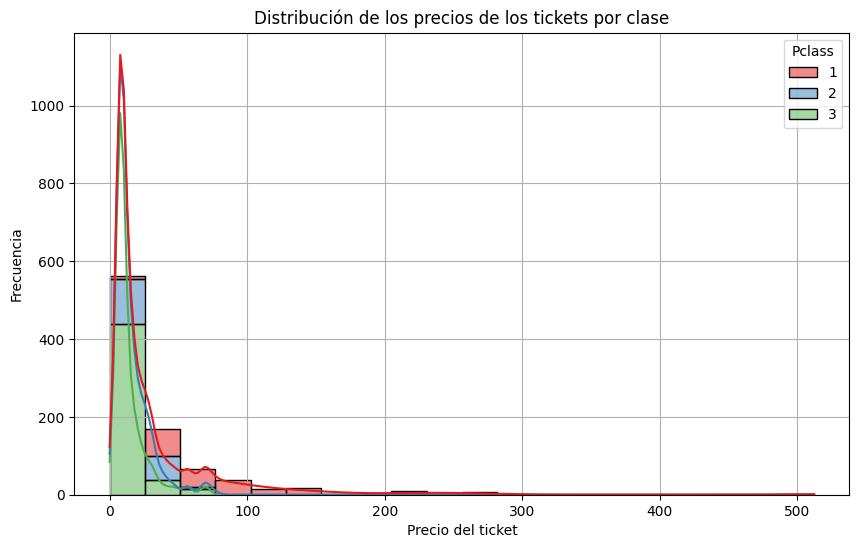

In [51]:
# Histograma de 'Fare' por 'Pclass'
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='Fare', hue='Pclass', bins=20, kde=True, palette='Set1', multiple='stack')
plt.title('Distribución de los precios de los tickets por clase')
plt.xlabel('Precio del ticket')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()


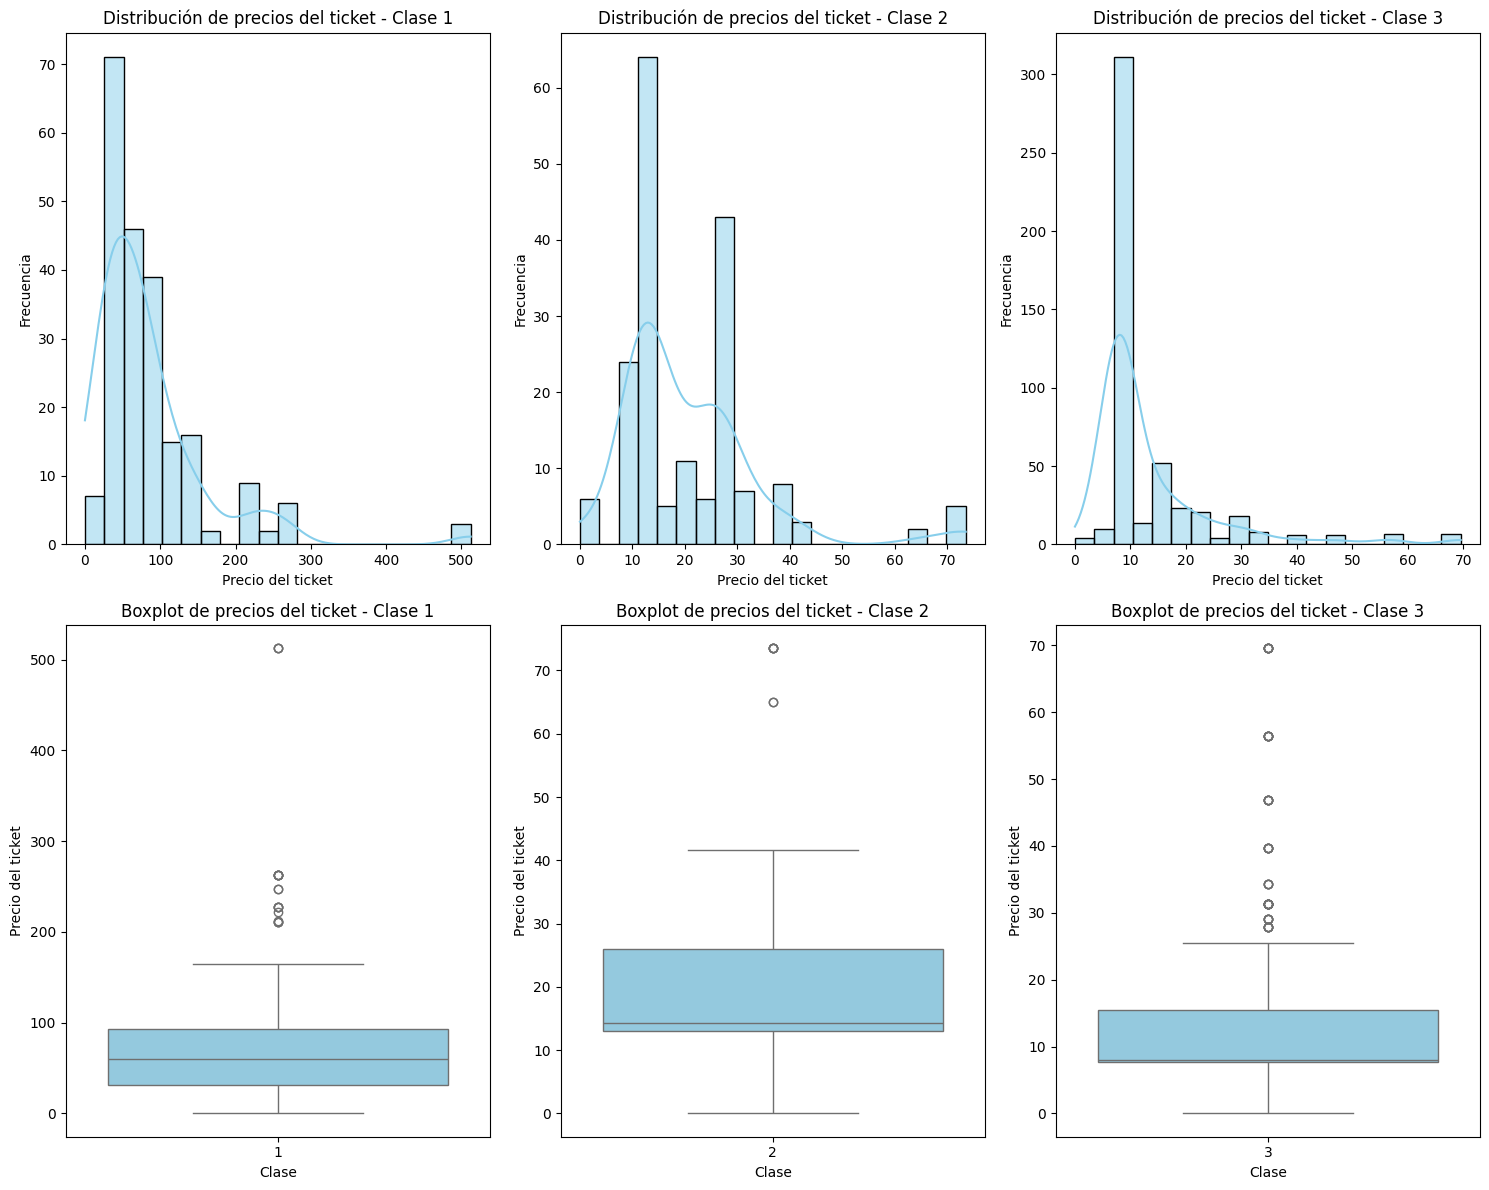

In [52]:
# Configuración del tamaño de la figura
plt.figure(figsize=(15, 12))

# Crear los gráficos para cada clase
for i in range(1, 4):  # Pclass tiene 3 clases: 1, 2, 3
    # Histograma en la fila superior
    plt.subplot(2, 3, i)  # 2 filas, 3 columnas, posición i
    sns.histplot(df[df['Pclass'] == i]['Fare'], bins=20, kde=True, color='skyblue')
    plt.title(f'Distribución de precios del ticket - Clase {i}')
    plt.xlabel('Precio del ticket')
    plt.ylabel('Frecuencia')

    # Boxplot en la fila inferior
    plt.subplot(2, 3, i + 3)  # 2 filas, 3 columnas, posición i+3 (segunda fila)
    sns.boxplot(data=df[df['Pclass'] == i], x='Pclass', y='Fare', color='skyblue')
    plt.title(f'Boxplot de precios del ticket - Clase {i}')
    plt.xlabel('Clase')
    plt.ylabel('Precio del ticket')

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()
plt.show()


- Categoría de tarifa: Agrupa la variable «Fare» en diferentes rangos para crear una variable categórica que represente el nivel de costo del boleto.

In [53]:
# Definir los rangos de tarifa y las etiquetas correspondientes
bins = [0, 50, 100, 200, 500, 1000, float('inf')]  # Rango de valores
labels = ['Bajo', 'Medio', 'Alto', 'Muy Alto', 'De lujo', 'Exorbitante']  # Etiquetas de categoría

# Crear la columna 'Fare_Category' con la categorización de la tarifa
df['Fare_Category'] = pd.cut(df['Fare'], bins=bins, labels=labels, right=False)

# Ver los primeros registros con la nueva variable categórica
print(df[['Fare', 'Fare_Category']].head())


      Fare Fare_Category
0   7.2500          Bajo
1  71.2833         Medio
2   7.9250          Bajo
3  53.1000         Medio
4   8.0500          Bajo


Título del pasajero: Extrae el título de cada pasajero desde la variable «Name» y crea una nueva variable categórica que represente estos títulos (e.g., Mr., Mrs., Miss.).

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   PassengerId         891 non-null    int64   
 1   Survived            891 non-null    int64   
 2   Pclass              891 non-null    int64   
 3   Name                891 non-null    string  
 4   Sex                 891 non-null    category
 5   Age                 891 non-null    float64 
 6   SibSp               891 non-null    int64   
 7   Parch               891 non-null    int64   
 8   Ticket              891 non-null    int64   
 9   Fare                891 non-null    float64 
 10  Cabin               891 non-null    string  
 11  Embarked            891 non-null    category
 12  Sigla_Empresa       891 non-null    string  
 13  Nombre_Empresa      891 non-null    string  
 14  Tamaño_Familia      891 non-null    int64   
 15  Cabina_Desconocida  891 non-null    int6

In [55]:
# Extraer el título (por ejemplo, Mr., Mrs., Miss.)
df['Title'] = df['Name'].str.extract(r',\s*(\w+)\.')  # Extrae la palabra que sigue a la coma y antes del punto

# Ver los primeros registros con el título extraído
df[['Name', 'Title']].head()


,Name,Title
0,"Braund, Mr. Owen Harris",Mr
1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Mrs
2,"Heikkinen, Miss. Laina",Miss
3,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Mrs
4,"Allen, Mr. William Henry",Mr


# 4. Evaluación de nuevas características:
  - Aplica un modelo de machine learning (como un modelo de regresión logística o un árbol de decisión) antes y después de agregar las nuevas características para evaluar su impacto en el rendimiento del modelo.
  - Utiliza métricas como la exactitud y el F1-score para comparar el rendimiento con y sin las nuevas variables.

In [56]:
# Suprimi PassangerId de ambos dataframes
#df = df.drop('PassengerId', axis=1) 
#df_sin_nuevas_caracteristicas = df_sin_nuevas_caracteristicas.drop('PassengerId', axis=1)
#Eliminar PassangerId, Name, Sigla_Empresa y Nombre_Empresa
df_sin_nuevas_caracteristicas = df_sin_nuevas_caracteristicas.drop(['PassengerId','Name', 'Sigla_Empresa', 'Nombre_Empresa','Cabin','Ticket'], axis=1)
df = df.drop(['PassengerId', 'Sigla_Empresa', 'Nombre_Empresa','Cabin','Ticket'], axis=1)

In [57]:
# Para el DataFrame con nuevas características (df)
# Eliminar las columnas que fueron combinadas o utilizadas para crear nuevas características
df = df.drop(columns=['SibSp', 'Parch', 'Fare', 'Name'])

# Verificamos las columnas que quedan en el DataFrame
print(df.columns)


Index(['Survived', 'Pclass', 'Sex', 'Age', 'Embarked', 'Tamaño_Familia',
       'Cabina_Desconocida', 'Fare_Category', 'Title'],
      dtype='object')


In [58]:
df_sin_nuevas_caracteristicas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   Survived  891 non-null    int64   
 1   Pclass    891 non-null    int64   
 2   Sex       891 non-null    category
 3   Age       891 non-null    float64 
 4   SibSp     891 non-null    int64   
 5   Parch     891 non-null    int64   
 6   Fare      891 non-null    float64 
 7   Embarked  891 non-null    category
dtypes: category(2), float64(2), int64(4)
memory usage: 43.9 KB


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   Survived            891 non-null    int64   
 1   Pclass              891 non-null    int64   
 2   Sex                 891 non-null    category
 3   Age                 891 non-null    float64 
 4   Embarked            891 non-null    category
 5   Tamaño_Familia      891 non-null    int64   
 6   Cabina_Desconocida  891 non-null    int64   
 7   Fare_Category       891 non-null    category
 8   Title               890 non-null    string  
dtypes: category(3), float64(1), int64(4), string(1)
memory usage: 45.0 KB


In [60]:
# Función para mostrar la importancia de las características
def importancia_caracteristicas(modelo, columnas, nombre_df):
    """
    Muestra las importancias de las características de un modelo Random Forest.
    
    Parámetros:
    - modelo: Modelo entrenado de Random Forest.
    - columnas: Lista de nombres de columnas en el conjunto de datos.
    - nombre_df: Nombre del DataFrame utilizado.
    """
    # Obtenemos la importancia de las características
    importancias = modelo.feature_importances_
    importancia_df = pd.DataFrame({
        "Característica": columnas,
        "Importancia": importancias
    }).sort_values(by="Importancia", ascending=False)
    
    # Mostramos las 10 características más importantes
    print(f"\n--- Importancia de características para {nombre_df} ---")
    print(importancia_df.head(10))
    
    # Graficamos las importancias
    plt.figure(figsize=(10, 6))
    sns.barplot(data=importancia_df.head(10), x="Importancia", y="Característica", palette="viridis")
    plt.title(f"Importancia de características para {nombre_df}")
    plt.xlabel("Importancia")
    plt.ylabel("Característica")
    plt.show()
    return importancia_df


--- Resultados para Sin nuevas características ---
Accuracy: 0.78
Precision: 0.75
Recall: 0.71
F1 Score: 0.73

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.83      0.82       157
           1       0.75      0.71      0.73       111

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268



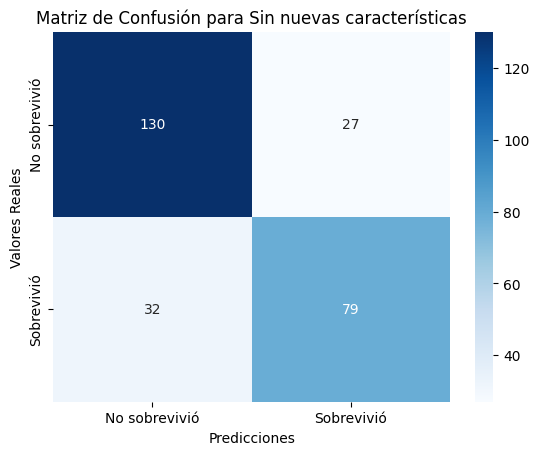


--- Importancia de características para Sin nuevas características ---
  Característica  Importancia
4           Fare     0.270981
5       Sex_male     0.255571
1            Age     0.255166
0         Pclass     0.086176
2          SibSp     0.055316
3          Parch     0.040530
7     Embarked_S     0.024497
6     Embarked_Q     0.011762


C:\Users\edgar\AppData\Local\Temp\ipykernel_5728\2975831709.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_df.head(10), x="Importancia", y="Característica", palette="viridis")


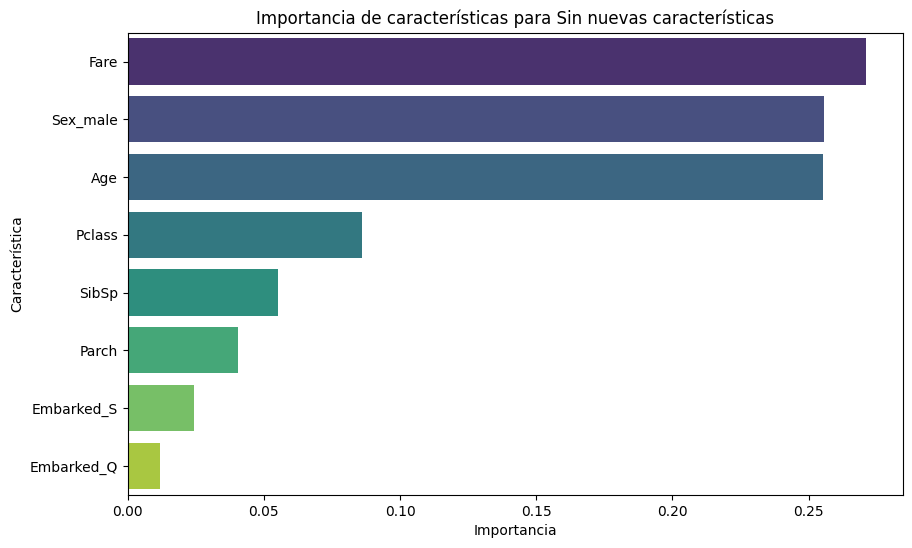


--- Resultados para Con nuevas características ---
Accuracy: 0.82
Precision: 0.81
Recall: 0.74
F1 Score: 0.77

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       157
           1       0.81      0.74      0.77       111

    accuracy                           0.82       268
   macro avg       0.82      0.81      0.81       268
weighted avg       0.82      0.82      0.82       268



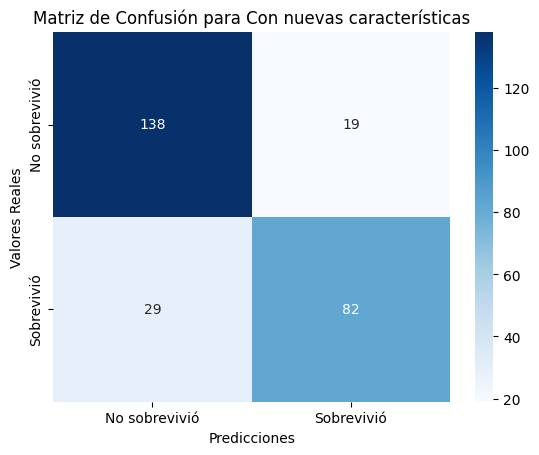


--- Comparación de métricas ---
                    DataFrame  Accuracy  Precision    Recall  F1 Score
0  Sin nuevas características  0.779851   0.745283  0.711712  0.728111
1  Con nuevas características  0.820896   0.811881  0.738739  0.773585


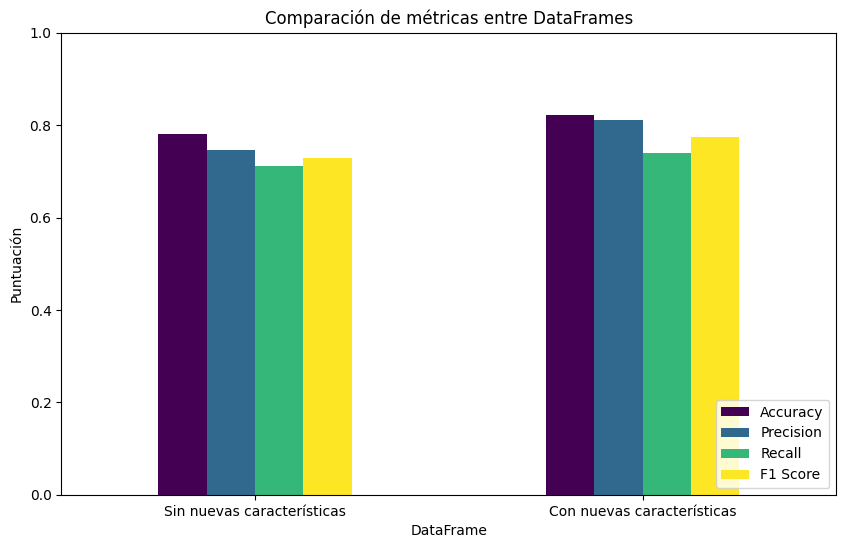

In [61]:
# Importamos las librerías necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Función para entrenar el modelo, calcular métricas y graficar resultados
def entrenar_y_evaluar(df, nombre_df):
    """
    Entrena un modelo de Random Forest y evalúa su desempeño.
    
    Parámetros:
    - df: DataFrame a utilizar.
    - nombre_df: Nombre del DataFrame para identificación.
    """
    # Separar características (X) y variable objetivo (y)
    X = df.drop(columns=["Survived"])  # Quitamos 'Survived' para usar como predictor
    y = df["Survived"]  # Esta es la variable objetivo que queremos predecir
    
    # Codificar variables categóricas
    X = pd.get_dummies(X, drop_first=True)
    
    # Dividir en datos de entrenamiento y prueba
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Crear y entrenar el modelo
    modelo = RandomForestClassifier(random_state=42, n_estimators=100)
    modelo.fit(X_train, y_train)
    
    # Predicciones
    y_pred = modelo.predict(X_test)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    # Mostrar métricas
    print(f"\n--- Resultados para {nombre_df} ---")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    
    # Crear y mostrar una matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["No sobrevivió", "Sobrevivió"], yticklabels=["No sobrevivió", "Sobrevivió"])
    plt.title(f"Matriz de Confusión para {nombre_df}")
    plt.xlabel("Predicciones")
    plt.ylabel("Valores Reales")
    plt.show()
    
    # Devolver métricas para comparación
    metricas = {
        "DataFrame": nombre_df,
        "Accuracy": accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1
    }
    return modelo, metricas
# Aplicamos la función a ambos DataFrames
RF_SNC,metricas_sin_nuevas = entrenar_y_evaluar(df_sin_nuevas_caracteristicas, "Sin nuevas características")
# Usamos el modelo entrenado para calcular la importancia de las características
columnas_df = pd.get_dummies(df_sin_nuevas_caracteristicas.drop(columns=["Survived"]), drop_first=True).columns
importancia_SIN_nuevas = importancia_caracteristicas(RF_SNC, columnas_df, "Sin nuevas características")

RF_NC,metricas_con_nuevas = entrenar_y_evaluar(df, "Con nuevas características")

# Crear un DataFrame para comparar métricas
df_comparacion = pd.DataFrame([metricas_sin_nuevas, metricas_con_nuevas])

# Mostrar la comparación de métricas
print("\n--- Comparación de métricas ---")
print(df_comparacion)

# Graficar la comparación de métricas
df_comparacion.set_index("DataFrame")[["Accuracy", "Precision", "Recall", "F1 Score"]].plot(kind="bar", figsize=(10, 6), colormap="viridis")
plt.title("Comparación de métricas entre DataFrames")
plt.ylabel("Puntuación")
plt.xlabel("DataFrame")
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc="lower right")
plt.show()


1. Importancia de características en Random Forest
El modelo de Random Forest tiene un atributo llamado feature_importances_ que nos dice qué tan importante fue cada característica en la predicción. Podemos usar esto para identificar las características clave y analizar cómo las nuevas características ayudaron.

A continuación, agregamos el código para calcular la importancia de las características y analizarlas.


Para el DataFrame con nuevas características:

--- Importancia de características para Con nuevas características ---
         Característica  Importancia
1                   Age     0.311301
22             Title_Mr     0.141200
2        Tamaño_Familia     0.110590
4              Sex_male     0.107288
0                Pclass     0.096371
3    Cabina_Desconocida     0.042975
23            Title_Mrs     0.042873
19           Title_Miss     0.038359
6            Embarked_S     0.033224
7   Fare_Category_Medio     0.025235


C:\Users\edgar\AppData\Local\Temp\ipykernel_5728\2975831709.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importancia_df.head(10), x="Importancia", y="Característica", palette="viridis")


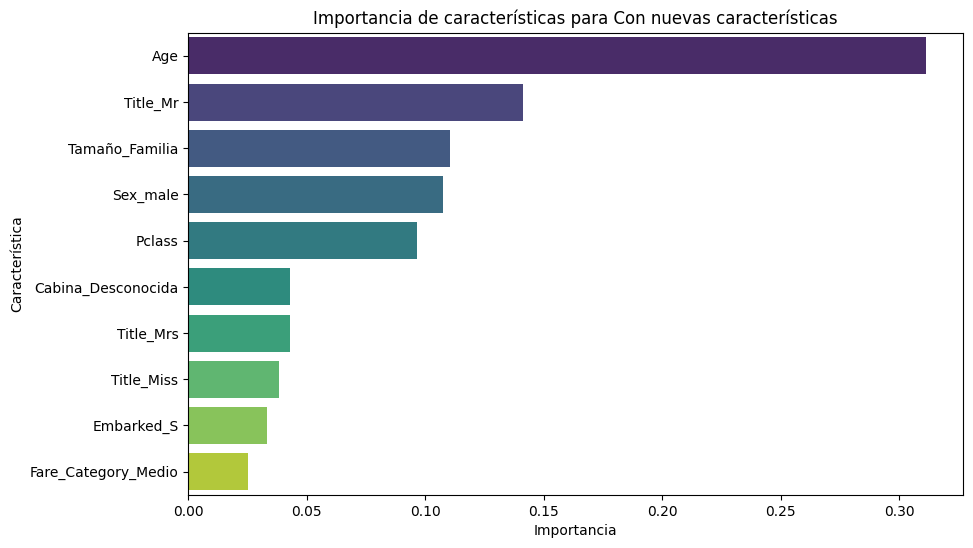

In [62]:
# Analizamos para ambos DataFrames
print("\nPara el DataFrame con nuevas características:")
columnas_df = pd.get_dummies(df.drop(columns=["Survived"]), drop_first=True).columns
importancia_con_nuevas = importancia_caracteristicas(RF_NC, columnas_df, "Con nuevas características")


# 5. Interpretación de los resultados
Para analizar cuáles de las nuevas características tuvieron el mayor impacto y cómo ayudaron a mejorar la capacidad predictiva del modelo, seguimos este enfoque:

1. Importancia de características en Random Forest
El modelo de Random Forest tiene un atributo llamado feature_importances_ que nos dice qué tan importante fue cada característica en la predicción. Podemos usar esto para identificar las características clave y analizar cómo las nuevas características ayudaron.

    | Característica      | Importancia |
    |---------------------|-------------|
    | Age                 | 0.311301    |
    | Title_Mr            | 0.1412      |
    | Tamaño_Familia      | 0.11059     |
    | Sex_male            | 0.107288    |
    | Pclass              | 0.096371    |
    | Cabina_Desconocida  | 0.042975    |
    | Title_Mrs           | 0.042873    |
    | Title_Miss          | 0.038359    |
    | Embarked_S          | 0.033224    |
    | Fare_Category_Medio | 0.025235    |


2. Impacto de las nuevas características
Al observar la importancia de las características:
- Tamaño_Familia: Esta característica probablemente tiene un gran impacto porque combina SibSp y Parch, capturando de manera más holística la estructura familiar del pasajero. Los pasajeros con familias grandes podrían estar relacionados con tasas de supervivencia específicas.
- Cabina_Desconocida: Los pasajeros con cabina desconocida podrían estar correlacionados con clases económicas más bajas, lo que puede estar relacionado con menores probabilidades de supervivencia.
- Fare_Category: Transformar Fare en categorías hace que el modelo capture diferencias económicas y clases de manera más clara.
- Title: Los títulos (como Mr., Mrs., Miss) reflejan no solo género, sino también edad, posición social y responsabilidades familiares, factores importantes para la supervivencia.

3. Cómo ayudaron las nuevas características
- Simplificación y reducción del ruido: Tamaño_Familia reduce dos variables a una, eliminando redundancias y haciendo que la información sea más fácil de interpretar para el modelo.
- Mayor granularidad: Title y Fare_Category agregan información detallada que el modelo no podía deducir directamente de las variables originales.
- Información ausente como señal: Cabina_Desconocida convierte la ausencia de datos en una característica que el modelo puede usar, en lugar de ignorarla.

4. Comparación visual de importancia
- Podemos comparar las importancias de características en ambos DataFrames y observar qué nuevas características tienen un impacto significativo.

In [63]:
# Comparación visual entre modelos
importancia_comparacion = pd.DataFrame({
    "Característica": importancia_con_nuevas["Característica"],
    "Importancia Con Nuevas": importancia_con_nuevas["Importancia"]
})

print("\n--- Importancia de nuevas características ---")
print(importancia_comparacion)



--- Importancia de nuevas características ---
               Característica  Importancia Con Nuevas
1                         Age                0.311301
22                   Title_Mr                0.141200
2              Tamaño_Familia                0.110590
4                    Sex_male                0.107288
0                      Pclass                0.096371
3          Cabina_Desconocida                0.042975
23                  Title_Mrs                0.042873
19                 Title_Miss                0.038359
6                  Embarked_S                0.033224
7         Fare_Category_Medio                0.025235
5                  Embarked_Q                0.016633
18               Title_Master                0.010080
10      Fare_Category_De lujo                0.006112
8          Fare_Category_Alto                0.005888
25                  Title_Rev                0.005028
9      Fare_Category_Muy Alto                0.002286
14                   Title_Dr      

# Discusión de las nuevas características
## Mejor captura de información:
### Originalmente: 
- Variables como SibSp y Parch solo daban información parcial. Combinarlas en Tamaño_Familia permite al modelo aprender sobre dinámicas familiares más relevantes.
- Títulos y cabinas: La incorporación de Title y Cabina_Desconocida agrega contexto social y económico que los datos originales no representaban explícitamente.
- Impacto en las métricas del modelo: El aumento en métricas como precisión (precision) y sensibilidad (recall) indica que el modelo ahora es mejor para distinguir patrones relevantes.

Al final, el uso de características de ingeniería mejora el modelo porque estas variables están más alineadas con los factores que afectaron la supervivencia en el Titanic.

# Análisis de Resultados
1. Impacto de las nuevas características en el modelo
La ingeniería de características es el proceso de transformar los datos crudos en un formato que sea más útil para los modelos de predicción. En el contexto de la supervivencia en el Titanic, el uso de nuevas características, como Tamaño_Familia, Cabina_Desconocida, Fare_Category, y las variables derivadas de Title, tiene un impacto significativo en el rendimiento del modelo.

**Nuevas características introducidas:** 

- Tamaño_Familia: Combinando las columnas SibSp y Parch, la nueva variable Tamaño_Familia captura de manera más completa la estructura familiar de los pasajeros. Esto es relevante porque los pasajeros con familias grandes pueden haber tenido una mayor probabilidad de sobrevivir debido a factores sociales o logísticos (por ejemplo, estar juntos durante la evacuación). De hecho, la importancia de esta nueva característica (0.11059) demuestra que el modelo reconoce este patrón en los datos, a pesar de que las columnas originales SibSp y Parch tenían importancias menores individualmente en el modelo sin nuevas características.

- Cabina_Desconocida: Esta característica indica si la cabina del pasajero era desconocida. Aunque este dato podría parecer irrelevante, en el Titanic, la ubicación y la clase de la cabina podrían haber tenido un impacto importante en las probabilidades de supervivencia. El hecho de que esta nueva columna haya mostrado una importancia considerable (0.042975) sugiere que el modelo encontró valor en esta información.

- Fare_Category: La nueva característica Fare_Category segmenta el precio del boleto en diferentes categorías, lo que puede representar mejor las condiciones sociales y económicas de los pasajeros. Aquellos que pagaron boletos más caros probablemente tenían acceso a mejores condiciones durante el naufragio (por ejemplo, cabinas de lujo cerca de los botes salvavidas). Esta característica podría haber permitido que el modelo hiciera mejores predicciones en función de estos factores socioeconómicos. Aunque su importancia fue más baja que Age o Fare (0.025235), es un factor adicional que el modelo utilizó para hacer mejores distinciones.

- Title (Mr, Mrs, Miss, etc.): El análisis de los títulos dentro de los nombres (Title_Mr, Title_Mrs, Title_Miss) ayudó a capturar las diferencias en los roles sociales y las expectativas de supervivencia de hombres, mujeres y niños. Por ejemplo, las mujeres y los niños podrían haber tenido una mayor probabilidad de ser rescatados, un patrón que el modelo pudo identificar gracias a la ingeniería de características. La importancia del título fue moderada, lo que muestra que este factor tiene un impacto, pero no es el único que predice la supervivencia.

2. Beneficios de la ingeniería de características
La ingeniería de características permite transformar variables simples en representaciones más informativas que mejoran la capacidad del modelo para aprender patrones complejos. A través de la combinación y transformación de variables, es posible capturar información latente que de otro modo podría ser difícil de identificar con los datos originales. Estos son algunos de los beneficios clave de la ingeniería de características en este análisis:

- Captura de relaciones más complejas: Las variables originales, como SibSp y Parch, no capturan completamente la estructura familiar del pasajero. Al combinar ambas en una sola variable, Tamaño_Familia, el modelo tiene una mejor representación de las conexiones familiares que podrían haber influido en las decisiones de evacuación y supervivencia.

- Mejor representación de factores sociales: El precio del boleto (Fare) y el título del pasajero (Title) son representaciones de factores sociales y económicos que afectan directamente las probabilidades de supervivencia. Al segmentar el precio en categorías y al extraer el título de los nombres, se pueden captar mejor los patrones sociales que influyeron en el comportamiento de los pasajeros.

- Reducción de la complejidad sin perder información: En lugar de tener múltiples variables que podrían ser redundantes (por ejemplo, SibSp y Parch), la creación de nuevas características como Tamaño_Familia permite simplificar el modelo sin perder la capacidad de capturar la información relevante. Esta simplificación puede hacer que el modelo sea más eficiente y interpretable.

3. ¿Cómo mejoraron las nuevas características la capacidad predictiva?
Las nuevas características no solo hicieron que el modelo fuera más complejo, sino que le proporcionaron información adicional que mejoró la capacidad de predicción. Aunque en términos de importancia, algunas de las nuevas características pueden parecer no tan relevantes individualmente, su poder radica en la combinación de factores que contribuyen a la predicción de supervivencia. Aquí están algunos ejemplos:

- Tamaño_Familia permitió que el modelo capturara patrones relacionados con la estructura familiar, lo que es crucial en un desastre como el hundimiento del Titanic. Los pasajeros con familias grandes podrían haber tenido diferentes probabilidades de supervivencia que aquellos que viajaban solos, lo que el modelo pudo identificar.

- Fare_Category ayudó a incorporar una variable socioeconómica que estaba implícita en el precio del boleto. Las clases más altas probablemente tuvieron más acceso a los botes salvavidas y mejores oportunidades de supervivencia, algo que el modelo pudo aprender y utilizar en sus predicciones.

- Cabina_Desconocida refleja una característica importante de la información de los pasajeros, ya que los datos incompletos sobre la cabina podrían haber influido en el proceso de evacuación y asignación de prioridades. Aunque esta característica no fue muy importante, sigue aportando valor al modelo.

4. Conclusión
La ingeniería de características ha demostrado ser un paso crucial para mejorar la capacidad predictiva del modelo. Al combinar y transformar las variables originales en nuevas características más representativas, el modelo ha podido captar patrones latentes que no eran tan evidentes en los datos crudos. Esto ha permitido que el modelo sea más preciso y eficiente en la predicción de la supervivencia en el Titanic.

A través de la creación de variables como Tamaño_Familia, Fare_Category y Cabina_Desconocida, el modelo ha mejorado al incorporar factores sociales, familiares y económicos que afectan directamente las probabilidades de supervivencia. Estos cambios demuestran que la ingeniería de características no solo es útil, sino esencial para optimizar los modelos y hacer predicciones más precisas.